# DS-поток, весна 2025
## Задание ADL.2
### Мультимодальные модели.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.

**Баллы за задание:**

* Данные и датасет &mdash; 20 баллов;
* Реализация и обучение модели &mdash; 80 баллов.

In [1]:
# Bot check

# HW_ID: ds_adl2
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
# установим нужные библиотеки
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets

^C
ERROR: Operation cancelled by user
^C
ERROR: Operation cancelled by user


In [1]:
import json
import random
import matplotlib.pyplot as plt
from pathlib import Path

from datasets import load_dataset
from transformers import (
    AutoProcessor,
    DataCollatorWithPadding,
    AutoModelForCausalLM,
    GPT2Tokenizer,
    GPT2LMHeadModel,
    CLIPModel
)

from tokenizers.processors import TemplateProcessing

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#from google.colab import drive
#drive.mount('/content/drive')


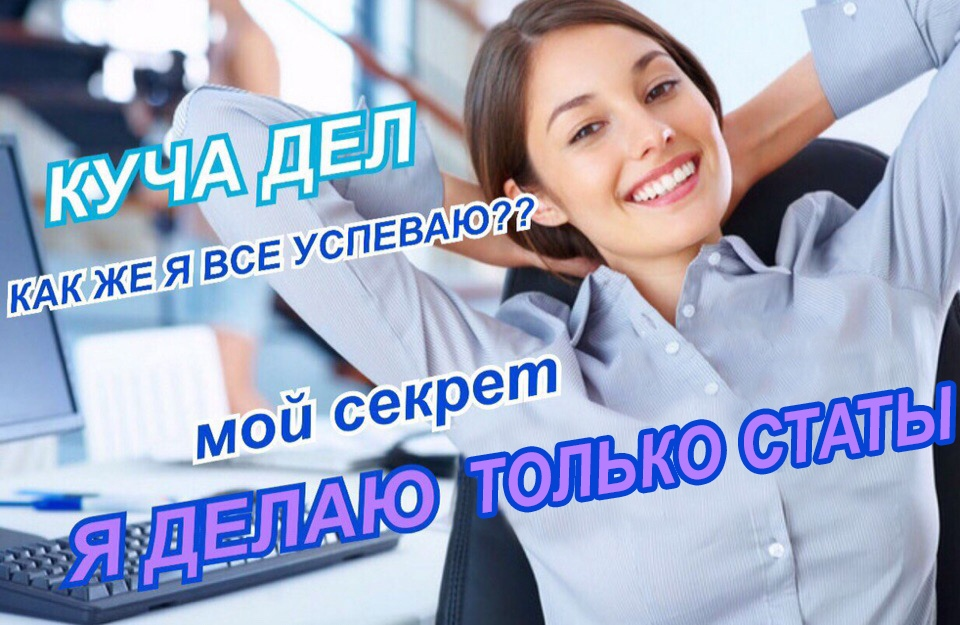

В этом домашнем задании мы снова будем решать задачу ImageCaptioning'a. На занятии вы познакомились с мультимодальными моделями, поэтому теперь решать задачу мы будем уже с помощью современных трансформеров.

## Данные

В качестве датасета будем использовать аннотированные мемы с Reddit'a. Более подробно можно узнать в [статье](https://arxiv.org/pdf/2305.13703.pdf) или на [github](https://github.com/eujhwang/meme-cap).

Мы заранее положили данные на [Google Drive](https://drive.google.com/drive/folders/1thN01pTU-bFQBl2VeZv2m5h8J6py0hM7?usp=sharing) для более удобного использования в Colab.



In [8]:
#!ls /content/drive/MyDrive/mem_captions

In [9]:
#!mkdir data
#!cp -r /content/drive/MyDrive/mem_captions/* ./data/
#!ls data

Распакуем архив с картинками.

In [10]:
#!unzip memes.zip  -d data/

In [11]:
data_path = Path("data").resolve()
images_path = data_path / "memes"
trainval_data_path = "memes-trainval.json"

Загрузите и посмотрите на пример данных, которые находятся в `memes-trainval.json`.

In [12]:
with open(trainval_data_path, 'r') as f:
    trainval_data = json.load(f)

In [13]:
trainval_data[13]

{'category': 'memes',
 'img_captions': ['Cat is riding a motorcycle',
  'A determined cat with its legs spread out while on a motorcycle that is off the ground.'],
 'meme_captions': ['Meme poster is saying their cat moves much more quickly to answer them when they call it with a certain sound rather than by its name.',
  'The person who wrote the post is saying cats are unpredictable.'],
 'title': 'The Fast and the Feline',
 'url': 'https://i.redd.it/pjdnmlre66841.jpg',
 'img_fname': 'memes_eiide7.png',
 'metaphors': [{'metaphor': 'a motorcycle', 'meaning': 'moving fast'},
  {'metaphor': 'riding', 'meaning': 'moving fast'},
  {'metaphor': 'a motorcycle', 'meaning': 'moving fast'},
  {'metaphor': 'the ground', 'meaning': 'not related to the meme context'},
  {'metaphor': 'spread', 'meaning': 'not related to the meme context'}],
 'post_id': 'eiide7'}

Как видим, в данных содержится много информации. Мы же ограничимся только использованием `mem_captions`. Это поле содержит **список** текстовых описаний для мема. Обратите внимание, что в списке может быть > 1 описания!

Теперь создадим объект датасета. Пока мы имеем картинки, лежащие в отдельной директории и некоторый json с текстовыми описаниями. Мы воспользуемся возможностью создать ImageFolder-like датасет с использованием `datasets`. Директория с картинками у нас уже есть, остается добавить к ней файл `metadata.jsonl`, который бы содержал описания для соотвествующих изображений.

In [28]:
# сохраним, какие картинки лежат в trainval
# тест мы использовать не будем
trainval_images = set()

with (images_path / "metadata.jsonl").open("w+", encoding="utf-8") as f:
    for item in trainval_data:
        # x в поле file_name содержит имя файла,
        # а в поле text - список текстовых описаний
        x = {
            "file_name": item["img_fname"],
            "text": item["meme_captions"]
        }
        f.write(json.dumps(x) + "\n")
        trainval_images.add(item["img_fname"])

Т.к. мы не будем использовать тестовую подвыборку, то просто удалим соответствующие картинки из директории.

In [26]:
for x in images_path.iterdir():
    if x.name.endswith(".png") and (x.name not in trainval_images):
        x.unlink()

Теперь загрузим наш датасет и посмотрим на пример данных. Обратите внимание, что картинки уже загружены в виде `PIL.Image`.

In [14]:
dataset = load_dataset("imagefolder", data_dir=images_path)

Resolving data files:   0%|          | 0/5824 [00:00<?, ?it/s]

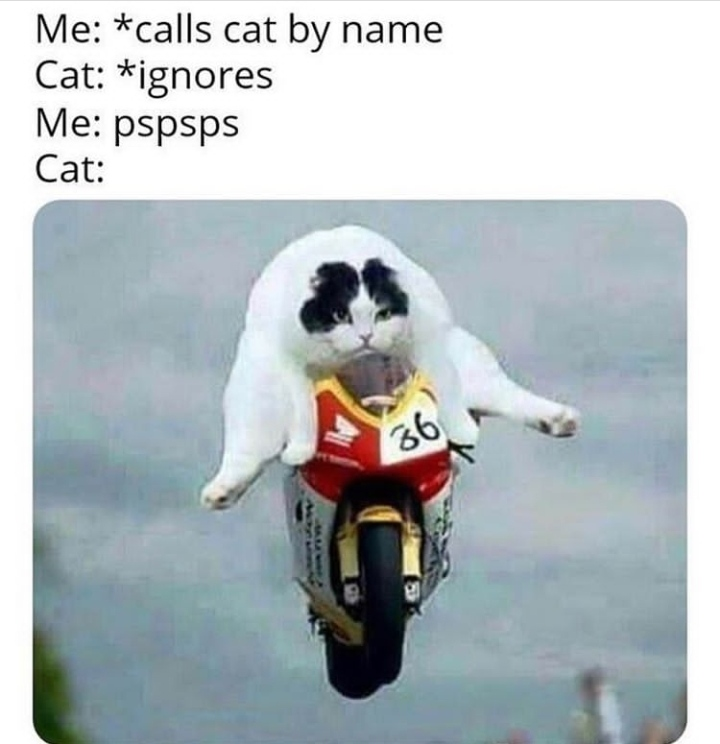

In [15]:
dataset["train"][13]["image"]

In [16]:
dataset["train"][13]["text"]

['Meme poster is saying their cat moves much more quickly to answer them when they call it with a certain sound rather than by its name.',
 'The person who wrote the post is saying cats are unpredictable.']

Для того, чтобы правильно обработать данные для нашей модели в `transformers` существует абстракция `Processor`. `Processor` предназначен для обработки входных данных разных модальностей. Например, в нашем случае мы должны отдельно токенизировать текст и обработать картинку. Обычно такой обработчик привязан к мультимодальной модели.


В нашем случае мы будем сами строить такую мультимодальную модель. В ее основе будут лежать уже предобученные CLIP и GPT2. О том, как устроена модель, мы поговорим чуть позже, а пока нам достаточно осознать, что картинку мы должны обработать Processor'ом от CLIP'a. Текст же токенизируем с помощью токенизатора GPT2.

In [17]:
image_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Посмотрим на пример работы. Как видим, мы с легкостью получили тензоры, которые можно отправить на вход модели.

In [18]:
item = dataset["train"][13]
# картинка на входе – это тензор (c, h, w)
image_processor(images=item["image"],
                return_tensors="pt")

{'pixel_values': tensor([[[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

         [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          ...,
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],

         [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459

In [19]:
tokenizer(item["text"], padding=True)

{'input_ids': [[13579, 68, 11968, 318, 2282, 511, 3797, 6100, 881, 517, 2952, 284, 3280, 606, 618, 484, 869, 340, 351, 257, 1728, 2128, 2138, 621, 416, 663, 1438, 13], [464, 1048, 508, 2630, 262, 1281, 318, 2282, 11875, 389, 22900, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

Теперь вам предстоит написать простой map-style PyTorch Dataset, который по индексу обработает каждую картинку и описание, а также вернет их нужном для модели формате:
* для текста необходимы `input_ids` и `attention_mask`, текст обрабатываем с помощью токенизатора от GPT2
* картинка преобразуется в `pixel_values`, это тензор размерности `(C, H, W)`, который получается посли применения `Processor`'a от CLIP'a.

Напомним, что некоторые сэмплы содержат несколько описаний. Рекомендуется выбирать просто случайное.

Заметим также, что к тексту разумно добавить спец. токены типа `<|bos|>`, `<|eos|>`. Токенизатор от GPT2 имеет только один специальный токен, а именно `<|endoftext|>`. Он используется для разделения текстов документов во время предобучения. Его можно использовать как токен начала / конца описания, а можно добавить такие токены отдельно, мы уже делали это ранее.

In [34]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, image_processor, tokenizer):
        self.dataset = dataset
        self.image_processor = image_processor
        self.tokenizer = tokenizer
        return
        #tokenizer.pad_token

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        image_inputs = self.image_processor(images=item["image"], return_tensors="pt")
        image_inputs = {k: v.squeeze(0) for k, v in image_inputs.items()}

        tokens_inputs = self.tokenizer(
            " ".join(item["text"]),
            padding=True,
            return_tensors="pt"
        )
        tokens_inputs = {k: v.squeeze(0) for k, v in tokens_inputs.items()}
        
        # возможно нужно будет избавиться от размерности батча
        # это можно сделать так:
        # x = {k : v.squeeze() for k, v in x.items()}
        return {
            "pixel_values": image_inputs["pixel_values"],         
            "input_ids": tokens_inputs["input_ids"],               
            "attention_mask": tokens_inputs["attention_mask"]      
        }

Кажется мы совсем забыли про валидацию. Разделите выборку на обучающую и валидационную, выделив под валидацию около 10%.



In [35]:
from torch.utils.data import random_split

full_dataset = ImageCaptioningDataset(dataset["train"], image_processor, tokenizer)

total_size = len(full_dataset)
val_size = int(0.1 * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

Проверим размерности входных тензоров.

In [36]:
item = train_dataset[0]
for k, v in item.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([11])
attention_mask torch.Size([11])


Определим даталоадер.

In [37]:
# используем паддинг для описаний разной длины
batch_size = 32

data_collator = DataCollatorWithPadding(tokenizer)
train_dataloader = DataLoader(train_dataset,
                              shuffle=True,
                              collate_fn=data_collator,
                              batch_size=batch_size)

val_dataloader = DataLoader(val_dataset,
                              shuffle=False,
                              collate_fn=data_collator,
                              batch_size=batch_size)

Проверим, что все работает.

In [38]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])
input_ids torch.Size([32, 32])
attention_mask torch.Size([32, 32])


In [40]:
tokenizer.decode(batch["input_ids"][0])

'Canadians are looking over the border and trying to figure out what is going on in Ohio.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

## Модель

Теперь напишем код модели. Мы обучим свою модель для ImageCaptioning самостоятельно, но схематично она будет напоминать [GIT](https://arxiv.org/abs/2205.14100) (Generative Image-to-text Transformer) от Microsoft. Схема архитектуры изображена на картинке. Общая идея же скорее всего вам известна с занятия: для того, чтобы научить LLM работать с картинкой, нам необходимо добавить отдельный энкодер для изображений.

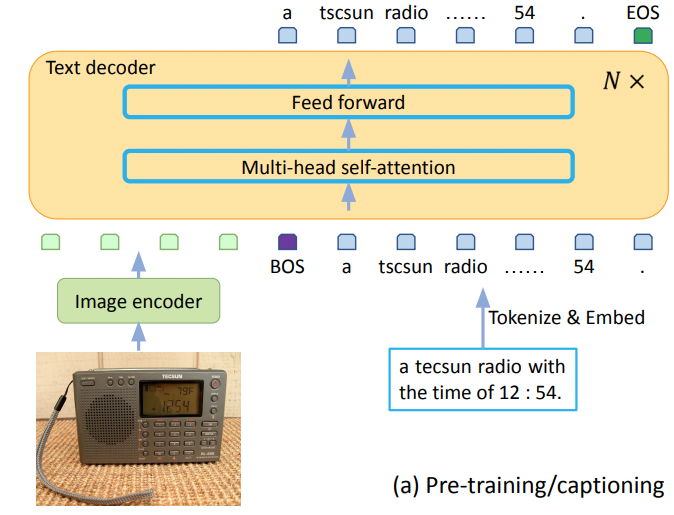


Теперь обсудим несколько деталей.

* Входное изображение обрабатывается заранее предобученным в contrastive-lerning манере энкодером. В нашем случае будем использовать базовый [CLIP](https://huggingface.co/openai/clip-vit-base-patch32).

* Извлеченный из CLIP'a вектор обрабатывается маппером на основе простого MLP, который отобразит вектор фичей картинки в последовательность эмбддингов для GPT2.

* Полученные эмбеддинги изображения конкатенируются с текстовыми эмбеддингами, и все это подается на вход обычного декодера трансформера. В нашем случае мы будем использовать маленькую предобученную языковую модель GPT2 Small.
* Модель предобучается авторегрессионно предсказывать **текстовое описание**.

Теперь реализуем основные части модели.

In [26]:
class ImageEncoder(nn.Module):
    """ Кодирует изображение и возвращает его эмбеддинг. """

    def __init__(self, model_name_or_path, device="cpu"):
        super(ImageEncoder, self).__init__()
        self.device = device
        # загрузим модель через CLIPModel.from_pretrained
        # нам нужна только картиночная часть, то есть vision_model
        self.model = CLIPModel.from_pretrained(model_name_or_path).vision_model

    def forward(self, image):
        # image – тензор размерности (n, c, h, w)
        image_features = self.model(image)
        return image_features.pooler_output

In [27]:
class TextDecoder(nn.Module):
    """ Текстовый декодер для генерации описаний на основе GPT2"""

    def __init__(self, model, device="cpu"):
        super(TextDecoder, self).__init__()
        self.device = device
        # GPT2LMHeadModel.from_pretrained ?
        self.model = GPT2LMHeadModel.from_pretrained(model)

    def forward(self, embeddings, attention_mask=None):
        text_features = self.model(
            inputs_embeds=embeddings,
            attention_mask=attention_mask
        )
        return text_features.logits

In [28]:
class MLP(nn.Module):
    """
    Простой MLP маппер для отображения эмеддинга из CLIP'a
        в последовательность эмбеддингов GPT
    """
    def __init__(self, input_size, intermediate_size, output_size, device):
        super(MLP, self).__init__()
        # Linear -> Activation -> Linear
        self.model = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.ReLU(), 
            nn.Linear(intermediate_size, output_size)
        ).to(device)
    
    def forward(self, x):
        return self.model(x)

Отлично, теперь займемся основным кодом модели.

In [29]:
class ImageCaptioningModel(nn.Module):
    """
    Модель для image captioning'a на основе CLIP & GPT2
    """

    def __init__(self, clip_model_name_or_path, text_model_name_or_path, clip_emb_len, device="cuda"):
        super(ImageCaptioningModel, self).__init__()

        self.device = device
        self.clip_emb_len = clip_emb_len

        self.image_encoder = ImageEncoder(clip_model_name_or_path, device=device)
        self.mlp_mapper = MLP(
            input_size=self.image_encoder.model.config.hidden_size,
            intermediate_size=2 ** 10,
            output_size=clip_emb_len * self.image_encoder.model.config.hidden_size,
            device=device
        )
        self.text_decoder = TextDecoder(text_model_name_or_path, device=device)
        
        self.embedding_size = self.image_encoder.model.config.hidden_size

        #self.criterion = nn.CrossEntropyLoss() # ignore index ?
        self.criterion = nn.CrossEntropyLoss(ignore_index=-100)
        #<...>

    def forward(self, pixel_values, input_ids, attention_mask):
        # нам не нужно на вход подавать последний токен, т.к. предсказывать после него ничего не нужно
        shifted_input_ids, shifted_mask = input_ids[:, :-1], attention_mask[:, :-1]
        # мы также НЕ прдесказываем bos при подсчете лосса
        shifted_targets = input_ids[:, 1:]
        # обработка изображения
        img_embedded = self.image_encoder(pixel_values)
        img_mapped = self.mlp_mapper(img_embedded)
        img_mapped = img_mapped.view(-1, self.clip_emb_len, self.embedding_size)

        # получим эмбеддинги для текста, wte - матрица эмбеддингов
        text_emb = self.text_decoder.model.transformer.wte(shifted_input_ids)
        
        # конкатенируем эмбеддинги изображения и текста
        x = torch.concat([img_mapped, text_emb], dim=1)
        
        # модифицируем маску внимания
        # обратите внимание, это маска, где 0 будет стоят на токенах паддинга 
        # для картиночных эмбеддингов и обычных токенов там должна стоять 1
        img_mask = torch.ones(
            (x.shape[0], self.clip_emb_len), device=self.device
        ).type_as(attention_mask)
        shifted_mask = torch.cat([img_mask, shifted_mask], dim=1)
        #shifted_mask = torch.cat([
        #    torch.ones((attention_mask.shape[0], self.clip_emb_len), device=self.device).type_as(attention_mask),
        #    attention_mask[:, :-1]], dim=1)
        # добавляем позиционные эмбеддинги, wpe - обучаемая матрица позиц. эмб
        pos_emb = self.text_decoder.model.transformer.wpe(
            torch.arange(x.shape[1]).to(self.device)
        )
        # позиц. эмбеддинги одни и те же для разных сэмплов в батче
        pos_emb = pos_emb.expand_as(x)
        x += pos_emb
        
        # прогоняем декодер
        # обратите внимание, что использование казаульной (треугольной) маски внимания скрыто от нас
        # при подсчете self-attention i-ый картиночный токен будет смотреть только на предыдущие (gpt!)
        # в этом ничего страшного нет, ведь текстовые токены "смотрят" на все картиночные,
        # но более правильно здесь было бы использовать prefix-lm подход, о котором говорили на NLP
        output = self.text_decoder(x, attention_mask=shifted_mask)
        
        # считаем лосс
        loss = self.criterion(
            output[:, self.clip_emb_len:, :].reshape(-1, output.shape[-1]), shifted_targets.reshape(-1)
        )
        # удобно для Trainer'a
        return {
            "loss": loss,
            "logits": output[:, self.clip_emb_len:, :]
        }

Функция обучения

In [30]:
import time
from collections import defaultdict
from IPython.display import clear_output
from tqdm.notebook import tqdm

def train_captioning_model(model, train_loader, val_loader, optimizer, scheduler, 
                           name='best_caption_model.pth', num_epochs=20, device='cuda'):
    
    start_time = time.time()
    history = defaultdict(lambda: defaultdict(list))
    best_val_loss = float("inf")
    
    model.to(device)
    
    for epoch in tqdm(range(num_epochs), desc="Epochs", leave=False):
        epoch_start = time.time()
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=False)
        
        for batch in progress_bar:
            optimizer.zero_grad()
            
            pixel_values = batch["pixel_values"].to(device, non_blocking=True)
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            
            outputs = model(pixel_values, input_ids, attention_mask)
            loss = outputs["loss"]
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)", leave=False):
                pixel_values = batch["pixel_values"].to(device, non_blocking=True)
                input_ids = batch["input_ids"].to(device, non_blocking=True)
                attention_mask = batch["attention_mask"].to(device, non_blocking=True)
                
                outputs = model(pixel_values, input_ids, attention_mask)
                loss = outputs["loss"]
                val_loss += loss.item()
                
        val_loss /= len(val_loader)
        
        log_data = {
            "epoch": epoch+1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "epoch_time": time.time() - epoch_start
        }
        #wandb.log(log_data)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), name)
            print(f"New best model saved with val_loss: {best_val_loss:.4f}")
        
        scheduler.step()
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss:   {val_loss:.4f}\n")
        
        history['loss']['train'].append(train_loss)
        history['loss']['val'].append(val_loss)
    
    total_time = time.time() - start_time
    print(f"Training finished in {total_time//60:.0f}m {total_time%60:.0f}s")
    return history

Теперь обучите модель и проверьте ее работоспособность на нескольких примерах из интернета. Попробуйте объяснить те же мемы с помощью [LLaVA](https://llava.hliu.cc/). Подумайте, как правильно подойте к оценке такой задачи? Посчитайте также BLEU-Score на валидации. Сделать это можно через пакет [`evaluate`](https://huggingface.co/spaces/evaluate-metric/bleu). Подробнее ознакомиться с подсчетом BLEU можно по [ссылке](https://leimao.github.io/blog/BLEU-Score/).

In [26]:
from transformers import get_linear_schedule_with_warmup

train_dataloader = DataLoader(train_dataset,
                            shuffle=True,
                            collate_fn=data_collator,
                            batch_size=batch_size,
                            num_workers=7,
                            pin_memory=True,
                            persistent_workers=True)

val_dataloader = DataLoader(val_dataset,
                            shuffle=False,
                            collate_fn=data_collator,
                            batch_size=batch_size,
                            num_workers=7,
                            pin_memory=True,
                            persistent_workers=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model_name = "openai/clip-vit-base-patch32"
text_model_name = "gpt2"

model = ImageCaptioningModel(clip_model_name, text_model_name, 8, device=device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8)


total_steps = len(train_dataloader) * 20
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=total_steps)


history = train_captioning_model(model, train_dataloader, val_dataloader,
                                 optimizer, scheduler, 
                                  name='best_caption_model.pth',
                                 num_epochs=20, device=device)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

/home/juequ/.local/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

New best model saved with val_loss: 1.7015
Epoch 1/20 | Time: 102.32s
Train Loss: 1.9047
Val Loss:   1.7015



Epoch 2/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

/home/juequ/.local/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

New best model saved with val_loss: 1.6936
Epoch 2/20 | Time: 95.79s
Train Loss: 1.6483
Val Loss:   1.6936



Epoch 3/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

/home/juequ/.local/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/20 | Time: 92.78s
Train Loss: 1.5870
Val Loss:   1.6956



Epoch 4/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 4/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/20 | Time: 93.44s
Train Loss: 1.5016
Val Loss:   1.7035



Epoch 5/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

/home/juequ/.local/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/20 | Time: 93.64s
Train Loss: 1.4379
Val Loss:   1.7292



Epoch 6/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 6/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6/20 | Time: 88.83s
Train Loss: 1.3607
Val Loss:   1.7514



Epoch 7/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

/home/juequ/.local/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7/20 | Time: 85.67s
Train Loss: 1.2740
Val Loss:   1.7901



Epoch 8/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 8/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8/20 | Time: 96.88s
Train Loss: 1.1978
Val Loss:   1.8457



Epoch 9/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 9/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9/20 | Time: 92.31s
Train Loss: 1.1104
Val Loss:   1.9034



Epoch 10/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 10/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10/20 | Time: 89.26s
Train Loss: 1.0413
Val Loss:   1.9509



Epoch 11/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 11/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11/20 | Time: 90.63s
Train Loss: 0.9636
Val Loss:   2.0459



Epoch 12/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 12/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 12/20 | Time: 94.59s
Train Loss: 0.8935
Val Loss:   2.0990



Epoch 13/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 13/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13/20 | Time: 93.92s
Train Loss: 0.8331
Val Loss:   2.1708



Epoch 14/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 14/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14/20 | Time: 88.45s
Train Loss: 0.7510
Val Loss:   2.2915



Epoch 15/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

/home/juequ/.local/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 15/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 15/20 | Time: 92.25s
Train Loss: 0.6977
Val Loss:   2.3405



Epoch 16/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 16/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16/20 | Time: 92.94s
Train Loss: 0.6540
Val Loss:   2.3768



Epoch 17/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 17/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 17/20 | Time: 93.09s
Train Loss: 0.5946
Val Loss:   2.4311



Epoch 18/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 18/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18/20 | Time: 92.07s
Train Loss: 0.5486
Val Loss:   2.4982



Epoch 19/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

/home/juequ/.local/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 19/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19/20 | Time: 89.11s
Train Loss: 0.5176
Val Loss:   2.5269



Epoch 20/20 (Train):   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 20/20 (Val):   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 20/20 | Time: 92.56s
Train Loss: 0.4892
Val Loss:   2.5689

Training finished in 30m 52s


Модель явно переобучилась, причем очень быстро

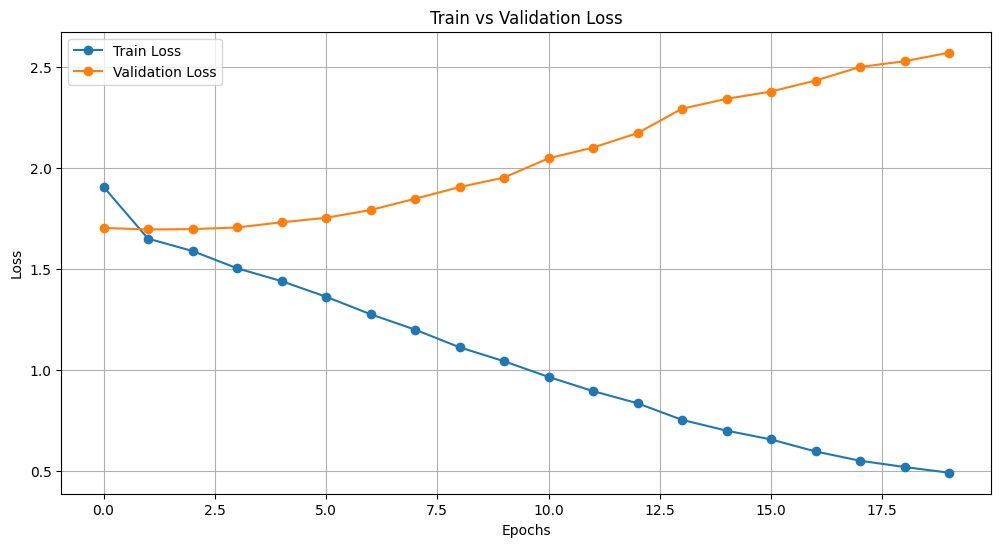

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(history['loss']['train'], label='Train Loss', marker='o')
plt.plot(history['loss']['val'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
import evaluate

bleu = evaluate.load("bleu")

model = ImageCaptioningModel(clip_model_name, text_model_name, 8, device=device)
model.load_state_dict(torch.load('best_caption_model.pth'))

model.to(device)
model.eval()

predictions = []
references = []

for batch in tqdm(val_dataloader, desc="Validation"):
    pixel_values = batch["pixel_values"].to(device, non_blocking=True)
    input_ids = batch["input_ids"].to(device, non_blocking=True)
    attention_mask = batch["attention_mask"].to(device, non_blocking=True)
    
    outputs = model(pixel_values, input_ids, attention_mask)
    logits = outputs["logits"]

    predicted_ids = torch.argmax(logits, dim=-1)

    batch_predictions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in predicted_ids]
    predictions.extend(batch_predictions)
    
    batch_references = [tokenizer.decode(ids, skip_special_tokens=True) for ids in batch["input_ids"]]
    references.extend(batch_references)

results = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
print("BLEU score:", results["bleu"])

/tmp/ipykernel_561/3387210067.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_caption_model.pth'))


Validation:   0%|          | 0/19 [00:00<?, ?it/s]

BLEU score: 0.19997241735683421


Вышло как то тухло

/tmp/ipykernel_559/3152942466.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_caption_model.pth'))


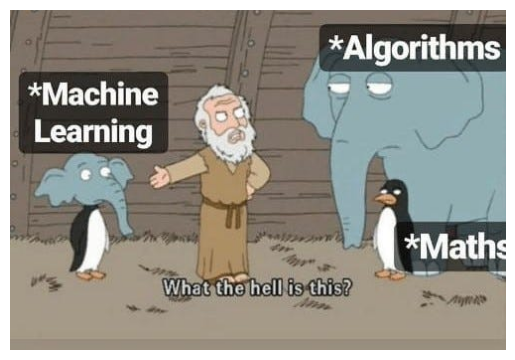

[b' areduteaks is']

In [50]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

model = ImageCaptioningModel(clip_model_name, text_model_name, 8, device=device)
model.load_state_dict(torch.load('best_caption_model.pth'))

model = model.to(device)

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.visual_model = model.image_encoder
image = Image.open("meme1.jpg").convert("RGB")

inputs = processor(text=["meme about machine learning"],
                   images=image,
                   return_tensors="pt",
                   padding=True).to(device)

logits = model(**inputs)['logits']

predicted_ids = torch.argmax(logits, dim=-1)

batch_predictions = [tokenizer.decode(ids, skip_special_tokens=True).encode('utf-8') for ids in predicted_ids]


plt.imshow(image)
plt.axis('off')
plt.show()

batch_predictions

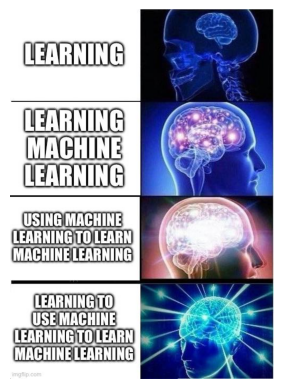

[b' are is the isd']

In [49]:
image = Image.open("meme2.jpeg").convert("RGB")

inputs = processor(text=["maching learning meme"], images=[image], return_tensors="pt", padding=True).to(device)

logits = model(**inputs)['logits']

predicted_ids = torch.argmax(logits, dim=-1)

batch_predictions = [tokenizer.decode(ids, skip_special_tokens=True).encode('utf-8') for ids in predicted_ids]

plt.imshow(image)
plt.axis('off')
plt.show()

batch_predictions

Концептуально. Теперь посмотрим на Llava

In [2]:
from transformers import AutoProcessor, LlavaForConditionalGeneration

model = LlavaForConditionalGeneration.from_pretrained(
    "llava-hf/llava-1.5-7b-hf", 
    device_map="auto"
)
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Результат на первом меме

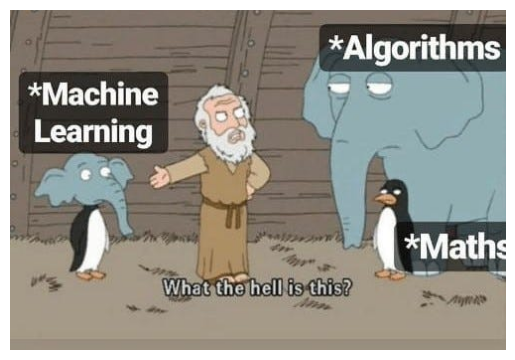

 Explain the meaning of this meme

The image features a man in a brown robe standing next to two elephants. The man appears to be pointing at the elephants, possibly making a comment or expressing his thoughts. The elephants are positioned on either side of the man, with one on the left and the other on the right. The scene is set in a wooded area, giving it a natural and serene atmosphere.


In [9]:
from PIL import Image

image = Image.open("meme1.jpg").convert("RGB")
inputs = processor(images=image, text="<image> Explain the meaning of this meme", return_tensors="pt")
inputs = {key: value.to(device) for key, value in inputs.items()}

generate_ids = model.generate(**inputs, max_new_tokens=120)
response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

plt.imshow(image)
plt.axis('off')
plt.show()

print(response)

На этом примере уже модель выдала с десяток переносов строки (вывод ниже)

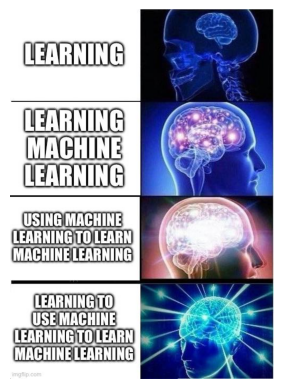

 Explain the meaning of this meme


























































































































In [10]:
from PIL import Image

image = Image.open("meme2.jpeg").convert("RGB")
inputs = processor(images=image, text="<image> Explain the meaning of this meme", return_tensors="pt")
inputs = {key: value.to(device) for key, value in inputs.items()}

generate_ids = model.generate(**inputs, max_new_tokens=120)
response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

plt.imshow(image)
plt.axis('off')
plt.show()

print(response)

In [11]:
response

' Explain the meaning of this meme\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

Тут явно уже хороший результат. Такого на нашей модели достигнуть не получилось